In [2]:
import math
import numpy as np
import sklearn
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns
import pandas as pd
import random
from scipy import stats  #t-test
from scipy.spatial.distance import euclidean
from scipy.interpolate import interp1d
from scipy import signal

import xlrd
from itertools import groupby

from statistics import mean
from matplotlib import cm
import csv

from scipy.spatial.distance import cdist

import mne
from mne.preprocessing import ICA, corrmap, create_eog_epochs
from autoreject import AutoReject

C:\Users\ljr\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
pathfp=r'F:\KyotoUdata\EEG\FP'
filesfp=sorted(os.listdir(pathfp))
pathsf=r'F:\KyotoUdata\EEG\SF'
filessf=sorted(os.listdir(pathsf))
pathre=r'F:\KyotoUdata\EEG\RE'
filesre=sorted(os.listdir(pathre))
pathst=r'F:\KyotoUdata\EEG\ST'
filesst=sorted(os.listdir(pathst))

In [4]:
def removespace(listin):
    for i in listin:
        if '' in listin:
            listin.remove('')
    return listin

In [5]:
def dataread(pathin):
    datap= pd.read_csv(pathin)
    columnlen=len(datap.iloc[:,0])
    head=[]
    with open (pathin) as f:
        test = list(csv.reader(f, delimiter=" "))
        test1=[x for x in test[:][0] if x!='']
        rowlen=len(test1)
    data=np.zeros((rowlen-1,columnlen))
    with open (pathin) as f:
        test = list(csv.reader(f, delimiter=" "))
        for i in range(columnlen):
            tem=[x for x in test[:][i] if x!='']
            data[:,i]=tem[1:]
            head.append(tem[0])
    return head,data

In [6]:
headfp1,datafp1=dataread(pathfp+'\\'+filesfp[0])
headfpc1=headfp1[:16]
headfpm1=headfp1[18:-1]

datafpc1=datafp1[:,:16]
datafpm1=datafp1[:,18:-1]

In [7]:
standard_ch_names = {
    'Fz_1': 'Fz', 'F3_1': 'F3', 'FC5_1': 'FC5', 'FC1_1': 'FC1',
    'C3_1': 'C3', 'CP1_1': 'CP1', 'Pz_1': 'Pz', 'P3_1': 'P3',
    'P7_1': 'P7', 'P4_1': 'P4', 'P8_1': 'P8', 'CP2_1': 'CP2',
    'C4_1': 'C4', 'FC6_1': 'FC6', 'FC2_1': 'FC2', 'F4_1': 'F4'
}

In [8]:
ch_names = list(standard_ch_names.values())
sfreq = 500
info = mne.create_info(ch_names, sfreq, ch_types='eeg')
samplesc1 = datafpc1.T
rawc1 = mne.io.RawArray(samplesc1, info)

samplesm1 = datafpm1.T
rawm1 = mne.io.RawArray(samplesm1, info)

Creating RawArray with float64 data, n_channels=16, n_times=60157
    Range : 0 ... 60156 =      0.000 ...   120.312 secs
Ready.
Creating RawArray with float64 data, n_channels=16, n_times=60157
    Range : 0 ... 60156 =      0.000 ...   120.312 secs
Ready.


In [9]:
montage = mne.channels.make_standard_montage('standard_1020')
rawc1.set_montage(montage)
rawm1.set_montage(montage)

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,19 points
Good channels,16 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


In [10]:
rawc1.set_channel_types({ch_name: 'eeg' for ch_name in rawc1.ch_names})
rawm1.set_channel_types({ch_name: 'eeg' for ch_name in rawm1.ch_names})

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,19 points
Good channels,16 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


In [11]:
rawc1.filter(1., 50., picks='all', fir_design='firwin', method='iir')
rawm1.filter(1., 50., picks='all', fir_design='firwin', method='iir')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 50.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 50.00 Hz: -6.02, -6.02 dB



Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,19 points
Good channels,16 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,50.00 Hz


In [12]:
# Segment the data into 1-second epochs with 500ms overlap
infant_epochs = mne.make_fixed_length_epochs(rawc1, duration=1.0, overlap=0.5, preload=True)
mother_epochs = mne.make_fixed_length_epochs(rawm1, duration=1.0, overlap=0.5, preload=True)

Not setting metadata
239 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 239 events and 500 original time points ...
0 bad epochs dropped
Not setting metadata
239 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 239 events and 500 original time points ...
0 bad epochs dropped


In [59]:
ar = AutoReject()
infant_epochs_clean = ar.fit_transform(infant_epochs)
mother_epochs_clean = ar.fit_transform(mother_epochs)

Running autoreject on ch_type=eeg








Estimated consensus=0.60 and n_interpolate=4



Dropped 78 epochs: 42, 43, 44, 61, 62, 63, 69, 70, 71, 72, 73, 74, 118, 119, 120, 149, 150, 151, 157, 158, 159, 162, 163, 164, 165, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 195, 204, 205, 206, 207, 208, 209, 213, 214, 215, 216, 217, 218, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238
Running autoreject on ch_type=eeg


C:\Users\ljr\anaconda3\lib\site-packages\mne\bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\ljr\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\ljr\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ljr\anaconda3\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(








Estimated consensus=1.00 and n_interpolate=15



Dropped 28 epochs: 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238


In [14]:
#ica_infant = ICA(n_components=16, random_state=97, max_iter=800)
#ica_infant.fit(infant_epochs_clean)
#ica_mother = ICA(n_components=16, random_state=97, max_iter=800)
#ica_mother.fit(mother_epochs_clean)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 16 components
Fitting ICA took 0.6s.
Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 16 components
Fitting ICA took 1.6s.


<ipython-input-14-57adb9fbb3ed>:4: RuntimeWarning: Using n_components=16 (resulting in n_components_=16) may lead to an unstable mixing matrix estimation because the ratio between the largest (5.5) and smallest (1.6e-23) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica_mother.fit(mother_epochs_clean)


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=800
Fit,31 iterations on epochs (105500 samples)
ICA components,16
Available PCA components,16
Channel types,eeg
ICA components marked for exclusion,—


In [15]:
# Apply CORRMAP to detect and exclude bad components
#template_ic = ica_infant.get_components()[:, 0]  # Select the first IC as a template, adjust as needed
#corrmap([ica_infant, ica_mother], template=template_ic, threshold=0.9, label="bad_ICs", plot=False)

Median correlation with constructed map: 1.000
No maps selected for subject [1], consider a more liberal threshold.


In [16]:
# Remove bad ICs
#ica_infant.exclude = ica_infant.labels_["bad_ICs"]
#ica_mother.exclude = ica_mother.labels_["bad_ICs"]


In [58]:
# Apply the IC removal to the epochs
#infant_epochs_clean = ica_infant.apply(infant_epochs_clean)
#mother_epochs_clean = ica_mother.apply(infant_epochs_clean)


TypeError: inst must be an instance of Raw, Epochs, or Evoked, got <class 'list'> instead.

In [20]:
from scipy.signal import hilbert

In [22]:
theta_band = (4, 8)

In [60]:
# Apply bandpass filter to isolate the theta band
infant_theta_epochs = infant_epochs_clean.copy().filter(theta_band[0], theta_band[1], fir_design='firwin')
mother_theta_epochs = mother_epochs_clean.copy().filter(theta_band[0], theta_band[1], fir_design='firwin')

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



<ipython-input-60-9ebb4587b1b7>:2: RuntimeWarning: filter_length (825) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  infant_theta_epochs = infant_epochs_clean.copy().filter(theta_band[0], theta_band[1], fir_design='firwin')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done 2576 out of 2576 | elapsed:    0.9s finished
<ipython-input-60-9ebb4587b1b7>:3: RuntimeWarning: filter_length (825) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  mother_theta_epochs = mother_epochs_clean.copy().filter(theta_band[0], theta_band[1], fir_design='firwin')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 3376 out of 3376 | elapsed:    1.2s finished


In [61]:
# Align epochs by selecting the minimum number of epochs between the two datasets
min_epochs = min(infant_theta_epochs.get_data().shape[0], mother_theta_epochs.get_data().shape[0])
infant_data = infant_theta_epochs.get_data()[:min_epochs, :, :]  # Shape: (min_epochs, n_channels, n_samples)
mother_data = mother_theta_epochs.get_data()[:min_epochs, :, :]  # Shape: (min_epochs, n_channels, n_samples)


<ipython-input-61-5ffa361c0e5b>:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  min_epochs = min(infant_theta_epochs.get_data().shape[0], mother_theta_epochs.get_data().shape[0])
<ipython-input-61-5ffa361c0e5b>:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  min_epochs = min(infant_theta_epochs.get_data().shape[0], mother_theta_epochs.get_data().shape[0])
<ipython-input-61-5ffa361c0e5b>:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  infant_data = infant_theta_epochs.get_data()[:min_epochs, :, :]  # Shape: (min_epochs, n_channels, n_samples)
<ipython-input-61-5ffa361c0e5b>:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warnin

In [80]:
# Initialize the wPLI matrix
n_channels = infant_data.shape[1]
wpli_matrix = np.zeros((n_channels, n_channels))
wpli_matrixc = np.zeros((n_channels, n_channels))
wpli_matrixm = np.zeros((n_channels, n_channels))

In [63]:
def compute_wpli(data1, data2):
    # Apply Hilbert transform to get the analytic signal
    analytic_signal1 = hilbert(data1)
    analytic_signal2 = hilbert(data2)

    # Compute the phase of the analytic signal
    phase1 = np.angle(analytic_signal1)
    phase2 = np.angle(analytic_signal2)

    # Calculate the phase difference
    phase_diff = phase1 - phase2

    # Calculate the imaginary part of the phase difference
    imag_phase_diff = np.imag(np.exp(1j * phase_diff))

    # Calculate the numerator and denominator for wPLI
    num = np.sum(np.abs(imag_phase_diff) * np.sign(imag_phase_diff), axis=-1)
    den = np.sum(np.abs(imag_phase_diff), axis=-1)

    # Calculate wPLI
    wpli = np.abs(num / den)

    return wpli.mean()

In [64]:
# Calculate wPLI for each pair of channels
for i in range(n_channels):
    for j in range(n_channels):
        wpli_matrix[i, j] = compute_wpli(infant_data[:, i, :], mother_data[:, j, :])

In [81]:
# Calculate wPLI for each pair of channels
for i in range(n_channels):
    for j in range(n_channels):
        wpli_matrixc[i, j] = compute_wpli(infant_data[:, i, :], infant_data[:, j, :])

<ipython-input-63-770034cfd5ea>:21: RuntimeWarning: invalid value encountered in divide
  wpli = np.abs(num / den)


In [82]:
# Calculate wPLI for each pair of channels
for i in range(n_channels):
    for j in range(n_channels):
        wpli_matrixm[i, j] = compute_wpli(mother_data[:, i, :], mother_data[:, j, :])

<ipython-input-63-770034cfd5ea>:21: RuntimeWarning: invalid value encountered in divide
  wpli = np.abs(num / den)


In [66]:
channelname=['Fz','F3','FC5','FC1','C3',
            'CP1','Pz','P3','P7','P4','P8',
            'CP2','C4','FC6','FC2','F4']
categories=['006','007','008','010','011','014','015','018','024','025',
           '026','030','032','033','034','035','037','038','041','042']

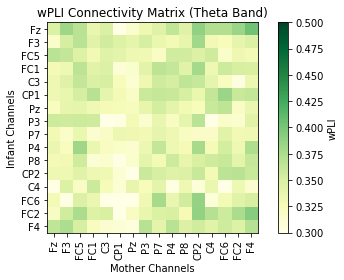

In [78]:
channel_names = infant_theta_epochs.info['ch_names']  # Assuming channel names are the same for both infant and mother

plt.figure(figsize=(6, 4))
plt.imshow(wpli_matrix, cmap='YlGn', vmin=0.3, vmax=0.5)
plt.colorbar(label='wPLI')
plt.title('wPLI Connectivity Matrix (Theta Band)')
plt.xticks(ticks=np.arange(n_channels), labels=channel_names, rotation=90)
plt.yticks(ticks=np.arange(n_channels), labels=channel_names)
plt.xlabel('Mother Channels')
plt.ylabel('Infant Channels')
plt.tight_layout()
plt.show()

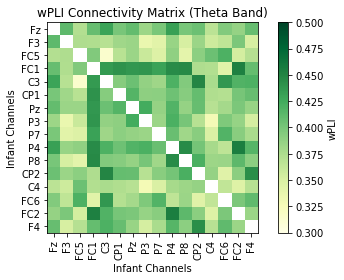

In [83]:
channel_names = infant_theta_epochs.info['ch_names']  # Assuming channel names are the same for both infant and mother

plt.figure(figsize=(6, 4))
plt.imshow(wpli_matrixc, cmap='YlGn', vmin=0.3, vmax=0.5)
plt.colorbar(label='wPLI')
plt.title('wPLI Connectivity Matrix (Theta Band)')
plt.xticks(ticks=np.arange(n_channels), labels=channel_names, rotation=90)
plt.yticks(ticks=np.arange(n_channels), labels=channel_names)
plt.xlabel('Infant Channels')
plt.ylabel('Infant Channels')
plt.tight_layout()
plt.show()

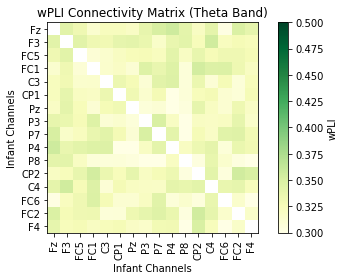

In [84]:
channel_names = infant_theta_epochs.info['ch_names']  # Assuming channel names are the same for both infant and mother

plt.figure(figsize=(6, 4))
plt.imshow(wpli_matrixm, cmap='YlGn', vmin=0.3, vmax=0.5)
plt.colorbar(label='wPLI')
plt.title('wPLI Connectivity Matrix (Theta Band)')
plt.xticks(ticks=np.arange(n_channels), labels=channel_names, rotation=90)
plt.yticks(ticks=np.arange(n_channels), labels=channel_names)
plt.xlabel('Infant Channels')
plt.ylabel('Infant Channels')
plt.tight_layout()
plt.show()